In [64]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import numpy as np
import matplotlib
#matplotlib.use('Agg')


### Aggregate data across wildcards/folders

In [65]:
# Data to aggregate: <path>/{participation}/{year}/{zone}/{palette}/summary.csv
# Fix {participation} and {palette}
desired_size = '10'
desired_palette = 'p1'

In [66]:
def carbon_drop(scenario):
    base_path = f'../results/paper{scenario}/csvs'
    aggregated_df = pd.DataFrame()
    ci_demand_total_df = pd.DataFrame()  # hold 'ci_demand_total' data

    # Loop through the directory structure
    for root, dirs, files in os.walk(base_path):
        components = root.split(os.sep)
        # print(components)  # for debugging

        # Pickup desired participation and palette
        if len(components) == 8 and components[4] == desired_size and components[7] == desired_palette:
            year, zone = components[5], components[6]

            if 'summary.csv' in files:
                file_path = os.path.join(root, 'summary.csv')
                df = pd.read_csv(file_path, index_col=0)

                # store demand data for normalization
                ci_demand_total_data = df.loc['ci_demand_total']  # Get the 'ci_demand_total' row
                ci_demand_total_data.name = (zone, year)

                if ci_demand_total_df.empty:
                    ci_demand_total_df = pd.DataFrame(columns=ci_demand_total_data.index, dtype=float)

                ci_demand_total_df = pd.concat([ci_demand_total_df, ci_demand_total_data.to_frame().T], ignore_index=False)

                #store zone emissions data
                emissions_zone_data = df.loc['emissions_zone']
                emissions_zone_data.name = (zone, year)

                if aggregated_df.empty:
                    aggregated_df = pd.DataFrame(columns=emissions_zone_data.index, dtype=float)

                aggregated_df = pd.concat([aggregated_df, emissions_zone_data.to_frame().T], ignore_index=False)

    # Pick necessary scenarios and rename
    aggregated_df.index.names = ['system']
    selected = [col for col in ['ref','cfe100', 'res100'] if col in aggregated_df.columns]
    aggregated_df = aggregated_df[selected]
    aggregated_df[f'diff{scenario}'] = aggregated_df['ref'] - aggregated_df['cfe100']
    aggregated_df.rename(columns={'cfe100': f'cfe100{scenario}'}, inplace=True)

    # Add CI demand into aggregated_df | 'ref' scen is arbitrary since they are same
    aggregated_df['ci_demand'] = ci_demand_total_df['ref']

    return aggregated_df


## Isolating profile and volume effects on carbon emissions in local zone

### Gather data

In [67]:
carbon_drop(scenario='')

,ref,cfe100,res100,diff,ci_demand
system,,,,,
"(IE, 2025)",4.168777,3.542470,3.689036,0.626307,1927200.0
"(DK, 2025)",5.389010,5.278307,5.295009,0.110703,1962240.0
"(DE, 2025)",118.810889,103.000312,107.080605,15.810577,33647160.0
"(PL, 2025)",83.804790,78.226967,79.258311,5.577824,9758640.0
"(IE, 2030)",2.478082,2.114343,2.279577,0.363740,1927200.0
"(DK, 2030)",0.921909,0.914581,0.916650,0.007328,1962240.0
"(DE, 2030)",50.380531,43.339646,47.396700,7.040885,33647160.0
"(PL, 2030)",15.583535,11.752734,13.355023,3.830801,9758640.0


In [68]:
carbon_drop(scenario='-noexcess')

,ref,cfe100-noexcess,diff-noexcess,ci_demand
system,,,,
"(IE, 2025)",4.177328,3.693141,0.484187,1927200.0
"(DK, 2025)",5.389010,5.299968,0.089042,1962240.0
"(DE, 2025)",118.827112,106.186434,12.640678,33647160.0
"(PL, 2025)",83.793742,78.802011,4.991731,9758640.0
"(IE, 2030)",2.492387,2.211865,0.280522,1927200.0
"(DK, 2030)",0.921567,0.914430,0.007137,1962240.0
"(DE, 2030)",50.382612,44.903481,5.479131,33647160.0
"(PL, 2030)",15.608990,13.274702,2.334288,9758640.0


In [69]:
df1 = carbon_drop(scenario='')
df2 = carbon_drop(scenario='-noexcess')
data = df1.copy()

for col in df2.columns:
    if col not in df1.columns:
        data[col] = df2[col]

In [70]:
data

,ref,cfe100,res100,diff,ci_demand,cfe100-noexcess,diff-noexcess
system,,,,,,,
"(IE, 2025)",4.168777,3.542470,3.689036,0.626307,1927200.0,3.693141,0.484187
"(DK, 2025)",5.389010,5.278307,5.295009,0.110703,1962240.0,5.299968,0.089042
"(DE, 2025)",118.810889,103.000312,107.080605,15.810577,33647160.0,106.186434,12.640678
"(PL, 2025)",83.804790,78.226967,79.258311,5.577824,9758640.0,78.802011,4.991731
"(IE, 2030)",2.478082,2.114343,2.279577,0.363740,1927200.0,2.211865,0.280522
"(DK, 2030)",0.921909,0.914581,0.916650,0.007328,1962240.0,0.914430,0.007137
"(DE, 2030)",50.380531,43.339646,47.396700,7.040885,33647160.0,44.903481,5.479131
"(PL, 2030)",15.583535,11.752734,13.355023,3.830801,9758640.0,13.274702,2.334288


In [71]:
rename_scen = {
    'ref': 'no procurement',
    'res100': '100% annual matching',
    'cfe100':'100% 24/7 CFE',
    'diff': 'Emissions reduction total',
    'cfe100-noexcess': '100% 24/7 CFE w/o excess',
    'diff-noexcess': 'Profile effect',
    'ci_demand': "ci demand"
        }

data.rename(columns=rename_scen, inplace=True)

In [72]:
data

,no procurement,100% 24/7 CFE,100% annual matching,Emissions reduction total,ci demand,100% 24/7 CFE w/o excess,Profile effect
system,,,,,,,
"(IE, 2025)",4.168777,3.542470,3.689036,0.626307,1927200.0,3.693141,0.484187
"(DK, 2025)",5.389010,5.278307,5.295009,0.110703,1962240.0,5.299968,0.089042
"(DE, 2025)",118.810889,103.000312,107.080605,15.810577,33647160.0,106.186434,12.640678
"(PL, 2025)",83.804790,78.226967,79.258311,5.577824,9758640.0,78.802011,4.991731
"(IE, 2030)",2.478082,2.114343,2.279577,0.363740,1927200.0,2.211865,0.280522
"(DK, 2030)",0.921909,0.914581,0.916650,0.007328,1962240.0,0.914430,0.007137
"(DE, 2030)",50.380531,43.339646,47.396700,7.040885,33647160.0,44.903481,5.479131
"(PL, 2030)",15.583535,11.752734,13.355023,3.830801,9758640.0,13.274702,2.334288


### Compute volume effect (i.e. overall impact minus profile part)

In [73]:
data['Volume effect'] = data['Emissions reduction total'] - data['Profile effect']

In [74]:
data

,no procurement,100% 24/7 CFE,100% annual matching,Emissions reduction total,ci demand,100% 24/7 CFE w/o excess,Profile effect,Volume effect
system,,,,,,,,
"(IE, 2025)",4.168777,3.542470,3.689036,0.626307,1927200.0,3.693141,0.484187,0.142120
"(DK, 2025)",5.389010,5.278307,5.295009,0.110703,1962240.0,5.299968,0.089042,0.021661
"(DE, 2025)",118.810889,103.000312,107.080605,15.810577,33647160.0,106.186434,12.640678,3.169899
"(PL, 2025)",83.804790,78.226967,79.258311,5.577824,9758640.0,78.802011,4.991731,0.586093
"(IE, 2030)",2.478082,2.114343,2.279577,0.363740,1927200.0,2.211865,0.280522,0.083218
"(DK, 2030)",0.921909,0.914581,0.916650,0.007328,1962240.0,0.914430,0.007137,0.000191
"(DE, 2030)",50.380531,43.339646,47.396700,7.040885,33647160.0,44.903481,5.479131,1.561754
"(PL, 2030)",15.583535,11.752734,13.355023,3.830801,9758640.0,13.274702,2.334288,1.496514


### Compute absolute & relative fractions of profile vs volume

In [75]:
fractions = pd.DataFrame()
fractions['Profile effect share'] = (data['Profile effect'] / data['Emissions reduction total']) * 100
fractions['Volume effect share'] = (data['Volume effect'] / data['Emissions reduction total']) * 100
fractions

,Profile effect share,Volume effect share
system,,
"(IE, 2025)",77.308203,22.691797
"(DK, 2025)",80.433387,19.566613
"(DE, 2025)",79.950769,20.049231
"(PL, 2025)",89.492447,10.507553
"(IE, 2030)",77.121691,22.878309
"(DK, 2030)",97.396118,2.603882
"(DE, 2030)",77.818789,22.181211
"(PL, 2030)",60.934708,39.065292


In [76]:
abs = pd.DataFrame()
abs['Profile effect'] = data['Profile effect']
abs['Volume effect'] = data['Volume effect']
abs['Demand'] = data['ci demand']
abs.round(2)

,Profile effect,Volume effect,Demand
system,,,
"(IE, 2025)",0.48,0.14,1927200.0
"(DK, 2025)",0.09,0.02,1962240.0
"(DE, 2025)",12.64,3.17,33647160.0
"(PL, 2025)",4.99,0.59,9758640.0
"(IE, 2030)",0.28,0.08,1927200.0
"(DK, 2030)",0.01,0.00,1962240.0
"(DE, 2030)",5.48,1.56,33647160.0
"(PL, 2030)",2.33,1.50,9758640.0


### Isolating profile and volume effects | Plot 1

In [77]:
def plot_absolute(data):
    """
    Plot absolute values of Profile and Volume effects
    """
    fig, ax = plt.subplots()
    fig.set_size_inches((6,4.5))

    data = data.sort_index()
    data.index = [f"{x[0]} {x[1]}" for x in data.index]

    data[['Profile effect', 'Volume effect']].plot(kind='bar', stacked=True,
                                                   ax=ax,
                                                   color=plt.cm.Paired(np.linspace(0, 1, 2)),
                                                   width=0.65, edgecolor="black", linewidth=0.05)

    plt.xticks(rotation=90)

    ax.grid(alpha=0.3)
    ax.set_axisbelow(True)
    ax.set_ylabel("Emissions reduction in local zone [MtCO$_2$/a]")
    plt.xlabel('')
    plt.axvline(x = 1.5, color = 'gray', linestyle="--")
    plt.axvline(x = 3.5, color = 'gray', linestyle="--")
    plt.axvline(x = 5.5, color = 'gray', linestyle="--")

    fig.tight_layout()
    fig.savefig("../results/paper/absolute_effects.pdf", transparent=True)
    plt.show()

In [78]:
norm_df = data.copy()
norm_df['Profile effect'] /= data['ci demand']
norm_df['Volume effect'] /= data['ci demand']

norm_df *= 1e9 # MtCO2/a -> kgCO2/a per MWh of C&I demand
norm_df.index = [f"{x[0]} {x[1]}" for x in norm_df.index]
norm_df[['Profile effect', 'Volume effect']].sum(axis=1).round(1)

IE 2025    325.0
DK 2025     56.4
DE 2025    469.9
PL 2025    571.6
IE 2030    188.7
DK 2030      3.7
DE 2030    209.3
PL 2030    392.6
dtype: float64

In [79]:
def plot_normalized(data):
    """
    Plot normalized values of Profile and Volume effects per MWh of C&I demand
    """
    norm_df = data.copy()
    norm_df['Profile effect'] /= data['ci demand']
    norm_df['Volume effect'] /= data['ci demand']

    norm_df *= 1e9 # MtCO2/a -> kgCO2/a per MWh of C&I demand
    norm_df.index = [f"{x[0]} {x[1]}" for x in norm_df.index]

    fig, ax = plt.subplots()
    fig.set_size_inches((6,4.5))

    norm_df[['Profile effect', 'Volume effect']].sort_index().plot(kind='bar', stacked=True,
                                                                  ax=ax,
                                                                  color=plt.cm.Paired(np.linspace(0, 1, 2)),
                                                                  width=0.65, edgecolor="black", linewidth=0.05)

    plt.xticks(rotation=90)

    ax.grid(alpha=0.3)
    ax.set_axisbelow(True)
    ax.set_ylabel(r"Emissions reduction in local zone [kgCO$_2$/a·MWh$^{-1}$]")
    plt.xlabel('')
    plt.axvline(x = 1.5, color = 'gray', linestyle="--")
    plt.axvline(x = 3.5, color = 'gray', linestyle="--")
    plt.axvline(x = 5.5, color = 'gray', linestyle="--")

    fig.tight_layout()
    fig.savefig("../results/paper/normalized_effects.pdf", transparent=True)
    plt.show()

In [80]:
def plot_percentage_fractions(data):
    """
    Plot percentage fractions of Profile and Volume effects
    """
    fractions = pd.DataFrame(index=data.index)
    fractions['Profile effect share'] = (data['Profile effect'] / data['Emissions reduction total']) * 100
    fractions['Volume effect share'] = (data['Volume effect'] / data['Emissions reduction total']) * 100

    fig, ax = plt.subplots()
    fig.set_size_inches((6,4.5))

    fractions.index = [f"{x[0]} {x[1]}" for x in fractions.index]
    fractions.sort_index().plot(kind='bar', stacked=True,
                                ax=ax,
                                color=plt.cm.Paired(np.linspace(0, 1, 2)),
                                width=0.65, edgecolor="black", linewidth=0.05)

    plt.xticks(rotation=90)

    ax.grid(alpha=0.3)
    ax.set_axisbelow(True)
    ax.set_ylabel("Emissions reduction in local zone\npercentage share of causing effect")
    ax.legend(loc='lower right')
    plt.xlabel('')
    plt.axvline(x = 1.5, color = 'gray', linestyle="--")
    plt.axvline(x = 3.5, color = 'gray', linestyle="--")
    plt.axvline(x = 5.5, color = 'gray', linestyle="--")

    fig.tight_layout()
    fig.savefig("../results/paper/percentage_fractions.pdf", transparent=True)
    plt.show()

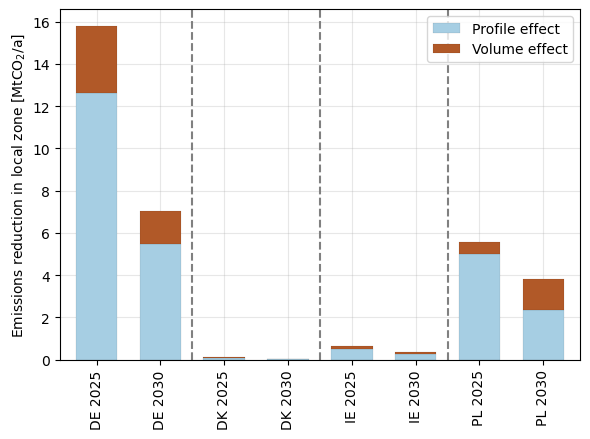

In [81]:
plot_absolute(data)

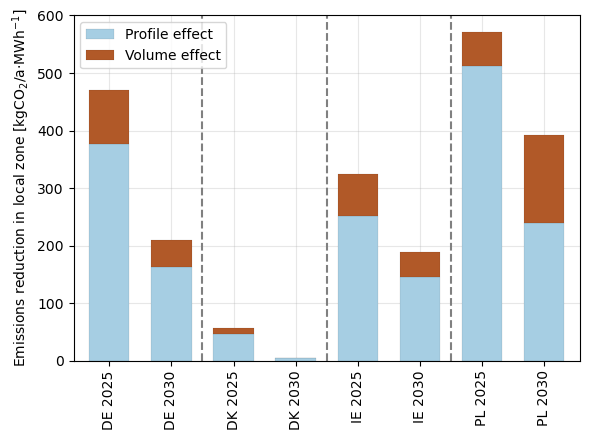

In [82]:
plot_normalized(data)

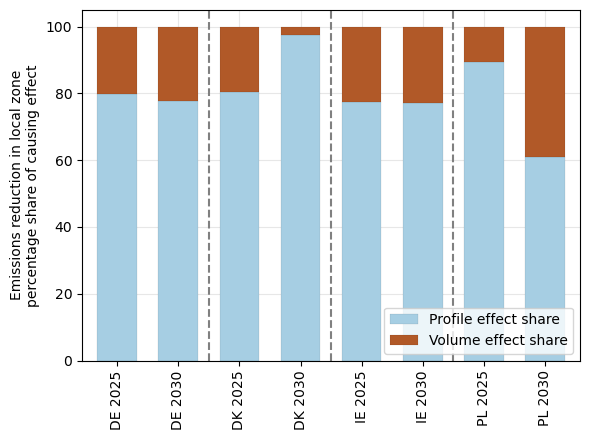

In [83]:
plot_percentage_fractions(data)

In [102]:
import matplotlib.colors as mcolors

# Get the color values
color_values = plt.cm.Paired(np.linspace(0, 1, 2))

# Convert to hexadecimal RGB string
color_hex = [mcolors.to_hex(color) for color in color_values]

print(color_hex)  # Output: ['#a6cee3', '#b15928']



['#a6cee3', '#b15928']


### Comparing emission reductions achieved by RES100% and 24/7 CFE 100% | Plot 2

In [84]:
data.round(1)

,no procurement,100% 24/7 CFE,100% annual matching,Emissions reduction total,ci demand,100% 24/7 CFE w/o excess,Profile effect,Volume effect
system,,,,,,,,
"(IE, 2025)",4.2,3.5,3.7,0.6,1927200.0,3.7,0.5,0.1
"(DK, 2025)",5.4,5.3,5.3,0.1,1962240.0,5.3,0.1,0.0
"(DE, 2025)",118.8,103.0,107.1,15.8,33647160.0,106.2,12.6,3.2
"(PL, 2025)",83.8,78.2,79.3,5.6,9758640.0,78.8,5.0,0.6
"(IE, 2030)",2.5,2.1,2.3,0.4,1927200.0,2.2,0.3,0.1
"(DK, 2030)",0.9,0.9,0.9,0.0,1962240.0,0.9,0.0,0.0
"(DE, 2030)",50.4,43.3,47.4,7.0,33647160.0,44.9,5.5,1.6
"(PL, 2030)",15.6,11.8,13.4,3.8,9758640.0,13.3,2.3,1.5


In [85]:
data.columns

Index(['no procurement', '100% 24/7 CFE', '100% annual matching',
       'Emissions reduction total', 'ci demand', '100% 24/7 CFE w/o excess',
       'Profile effect', 'Volume effect'],
      dtype='object')

In [125]:
# Calculate percentage reductions
data_copy['Annual Matching Reduction (%)'] = (1 - data_copy['100% annual matching'] / data_copy['no procurement']) * 100
data_copy['Profile Effect Reduction (%)'] = (data_copy['Profile effect'] / data_copy['no procurement']) * 100
data_copy['Volume Effect Reduction (%)'] = (data_copy['Volume effect'] / data_copy['no procurement']) * 100
data_copy


,no procurement,100% 24/7 CFE,100% annual matching,Emissions reduction total,ci demand,100% 24/7 CFE w/o excess,Profile effect,Volume effect,Annual Matching Reduction (%),Profile Effect Reduction (%),Volume Effect Reduction (%),CFE Reduction (%)
DE 2025,118.810889,103.000312,107.080605,15.810577,33647160.0,106.186434,12.640678,3.169899,9.873071,10.639326,2.668021,13.307347
DE 2030,50.380531,43.339646,47.396700,7.040885,33647160.0,44.903481,5.479131,1.561754,5.922588,10.875493,3.099915,13.975408
DK 2025,5.389010,5.278307,5.295009,0.110703,1962240.0,5.299968,0.089042,0.021661,1.744312,1.652291,0.401944,2.054235
DK 2030,0.921909,0.914581,0.916650,0.007328,1962240.0,0.914430,0.007137,0.000191,0.570414,0.774152,0.020697,0.794849
IE 2025,4.168777,3.542470,3.689036,0.626307,1927200.0,3.693141,0.484187,0.142120,11.507949,11.614606,3.409163,15.023769
IE 2030,2.478082,2.114343,2.279577,0.363740,1927200.0,2.211865,0.280522,0.083218,8.010427,11.320137,3.358142,14.678279
PL 2025,83.804790,78.226967,79.258311,5.577824,9758640.0,78.802011,4.991731,0.586093,5.425083,5.956379,0.699355,6.655734
PL 2030,15.583535,11.752734,13.355023,3.830801,9758640.0,13.274702,2.334288,1.496514,14.300428,14.979192,9.603172,24.582364


In [106]:
# def plot_2():

#     fig, ax = plt.subplots()
#     fig.set_size_inches((6,4.5))

#     df = pd.DataFrame()
#     # Compute decrease of local zone emissions achived 24/7 CFE *above* RES100% in % terms of no procurement case
#     df['Emissions_drop'] = (data['100% 24/7 CFE'] - data['100% annual matching'])/data['no procurement']*100
#     ldf = df.sort_index()
#     ldf.index = [f"{x[0]} {x[1]}" for x in df.index]
#     ldf.plot(kind="bar", ax=ax, 
#         color='#33415c', width=0.65, edgecolor = "black", linewidth=0.05)
 
#     plt.xticks(rotation=90)

#     ax.grid(alpha=0.3)
#     ax.set_axisbelow(True)
#     ax.set_ylabel("Percentage of local zone emissions [%]")
#     ax.get_legend().remove()
#     plt.xlabel('')
#     plt.axvline(x = 1.5, color = 'gray', linestyle="--")
#     plt.axvline(x = 3.5, color = 'gray', linestyle="--")
#     plt.axvline(x = 5.5, color = 'gray', linestyle="--")

#     fig.tight_layout()
#     fig.savefig("../results/paper/hourly-annual.pdf", transparent=True)

# plot_2()

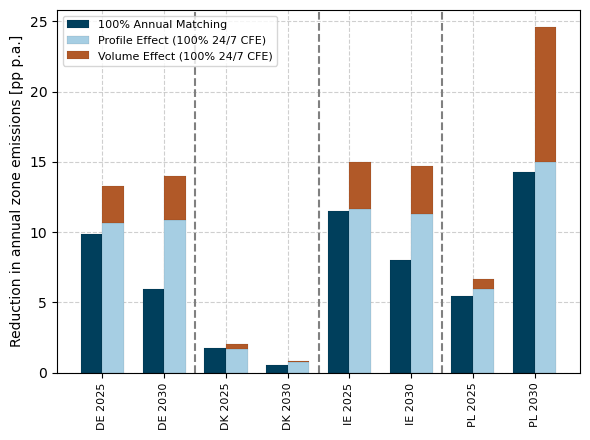

In [123]:
def plot_percentage_reduction(data):
    """
    Plots the reduction in annual annual zone emissions in % (counterfactual is no voluntary procurement) 
    for annual and hourly matching (hourly is split per causing effect).
    """

    data_copy = data.copy() 

    # Calculate percentage reductions
    data_copy['Annual Matching Reduction (%)'] = (1 - data_copy['100% annual matching'] / data_copy['no procurement']) * 100
    data_copy['Profile Effect Reduction (%)'] = (data_copy['Profile effect'] / data_copy['no procurement']) * 100
    data_copy['Volume Effect Reduction (%)'] = (data_copy['Volume effect'] / data_copy['no procurement']) * 100

    # Set the index for better labeling
    data_copy.index = [f"{x[0]} {x[1]}" for x in data_copy.index]
    data_copy = data_copy.sort_index()

    # Setup the plot
    n_zones = len(data_copy)
    bar_width = 0.35  # Adjusted the bar width to make bars a bit thicker
    index = np.arange(n_zones)  # The label locations
    fig, ax = plt.subplots(figsize=(6, 4.5))


    # Create bars
    bar1 = ax.bar(index - bar_width/2, data_copy['Annual Matching Reduction (%)'], bar_width, label='100% Annual Matching',
                 edgecolor="black", linewidth=0.05, color='#003f5c')
    bar2 = ax.bar(index + bar_width/2, data_copy['Profile Effect Reduction (%)'], bar_width, label='Profile Effect (100% 24/7 CFE)',
                  edgecolor="black", linewidth=0.05, color='#a6cee3')
    bar3 = ax.bar(index + bar_width/2, data_copy['Volume Effect Reduction (%)'], bar_width, label='Volume Effect (100% 24/7 CFE)',
                  bottom=data_copy['Profile Effect Reduction (%)'], edgecolor="black", linewidth=0.05, color='#b15928')

    # Decorations
    ax.set_ylabel(r'Reduction in annual zone emissions [pp p.a.]', fontsize=10)
    ax.set_xticks(index)
    ax.set_xticklabels(data_copy.index, fontsize=8)
    ax.legend(fontsize=8)
    ax.set_axisbelow(True)
    
    plt.xticks(rotation=90)
    plt.grid(True, linestyle='--', alpha=0.6)
    
    # Add vertical separating lines
    plt.axvline(x = 1.5, color = 'gray', linestyle="--")
    plt.axvline(x = 3.5, color = 'gray', linestyle="--")
    plt.axvline(x = 5.5, color = 'gray', linestyle="--")

    plt.tight_layout()
    fig.savefig("../results/paper/emissions_reduction_comparison.pdf", transparent=True)
    plt.show()

plot_percentage_reduction(data)
